# Introduction

## The Problem:

The bank recently experienced a decline in the number of subcriptions for their [term deposit](https://www.investopedia.com/terms/t/termdeposit.asp). They have come up with ads for their existing clients to address this and would like to do a targeted marketing approach. They would like to predict which of their clients have a higher chance to subscribe for a term deposit.

## Objective: 
- To understand what factors contributed most to term deposit subscription.

- To perform clustering to find any meaningful patterns of employee traits.

- To create a model that predicts the likelihood if a certain client will subscribe for a term deposit or not. 

- To create or improve different marketing strategies for clients that are least likely to subscribe for a term deposit.


The implementation of this model will allow the bank to create better marketing strategies.

## Categories of Analytics covered:
1. Descriptive Analytics - What happened?
2. Predictive Analytics - What might happen?
3. Prescriptive Analytics - What should we do?

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Load Data

In [2]:
full_dataset = pd.read_csv('data/bank.csv')

In [3]:
full_dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


### Data Quality Check

In [4]:
# check for missing values
full_dataset.isnull().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
deposit      False
dtype: bool

### Input variables:
#### Client data:
1 - age (numeric) <br>
2 - job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self employed', 'services', 'student', 'technician', 'unemployed', 'unknown') <br>
3 - marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed) <br>
4 - education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown') <br>
5 - default: has credit in default? (categorical: 'no', 'yes', 'unknown') <br>
6 - balance: average yearly balance (numeric) <br>
7 - housing: has housing loan? (categorical: 'no', 'yes', 'unknown') <br>
8 - loan: has personal loan? (categorical: 'no', 'yes', 'unknown') <br>

#### Campaign data:
9 - contact: contact communication type (categorical: 'cellular','telephone') <br>
10 - day: last contact day of month (numeric) <br>
11 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') <br>
12 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. <br>
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) <br>
14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted) <br>
15 - previous: number of contacts performed before this campaign and for this client (numeric) <br>
16 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') <br>


#### Target variable:
17 - deposit: has the client subscribed a term deposit? (binary: 'yes','no')

In [5]:
# rename columns
full_dataset = full_dataset.rename( columns = { 'contact' : 'contact_mode', 
                                              'campaign' : 'current_contacts',
                                              'pdays' : 'previous_days',
                                              'previous' : 'previous_contacts',
                                              'poutcome' : 'previous_outcome'})

In [6]:
# change values of deposit to 0 (did not subscribe) and 1 (subscribed)

new_dict = {'yes' : 1, 'no' : 0}

full_dataset = full_dataset.replace({'deposit' : new_dict})

In [7]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                11162 non-null  int64 
 1   job                11162 non-null  object
 2   marital            11162 non-null  object
 3   education          11162 non-null  object
 4   default            11162 non-null  object
 5   balance            11162 non-null  int64 
 6   housing            11162 non-null  object
 7   loan               11162 non-null  object
 8   contact_mode       11162 non-null  object
 9   day                11162 non-null  int64 
 10  month              11162 non-null  object
 11  duration           11162 non-null  int64 
 12  current_contacts   11162 non-null  int64 
 13  previous_days      11162 non-null  int64 
 14  previous_contacts  11162 non-null  int64 
 15  previous_outcome   11162 non-null  object
 16  deposit            11162 non-null  int64

In [8]:
# check subcription rate to determine if dataset is balanced
subscription_rate = full_dataset.deposit.value_counts() / 11162
subscription_rate

0    0.52616
1    0.47384
Name: deposit, dtype: float64

#### With a difference of ~ 5%, the dataset is almost balanced!

In [9]:
# descriptive stats for numerical columns
full_dataset.describe()

,age,balance,day,duration,current_contacts,previous_days,previous_contacts,deposit
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557,0.473840
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007,0.499338
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000,1.000000


In [10]:
# grouped by subscription outcome
subscription_summary = full_dataset.groupby('deposit')
subscription_summary.mean()

,age,balance,day,duration,current_contacts,previous_days,previous_contacts
deposit,,,,,,,
0,40.837391,1280.227141,16.108122,223.130257,2.839264,35.685340,0.528350
1,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354


In [11]:
subscription_summary.std()

,age,balance,day,duration,current_contacts,previous_days,previous_contacts
deposit,,,,,,,
0,10.264815,2933.411934,8.322071,208.577530,3.244474,96.182893,1.979610
1,13.497781,3501.104777,8.501875,392.525262,1.921826,118.822266,2.553272


#### There is an indicator that the duration of last contact, the number of days since the last contact and the number of previous contacts are important features as they have the largest relative diffrence in terms of subscription outcome.

,age,balance,day,duration,current_contacts,previous_days,previous_contacts,deposit
age,1.000000,0.112300,-0.000762,0.000189,-0.005278,0.002774,0.020169,0.034901
balance,0.112300,1.000000,0.010467,0.022436,-0.013894,0.017411,0.030805,0.081129
day,-0.000762,0.010467,1.000000,-0.018511,0.137007,-0.077232,-0.058981,-0.056326
duration,0.000189,0.022436,-0.018511,1.000000,-0.041557,-0.027392,-0.026716,0.451919
current_contacts,-0.005278,-0.013894,0.137007,-0.041557,1.000000,-0.102726,-0.049699,-0.128081
previous_days,0.002774,0.017411,-0.077232,-0.027392,-0.102726,1.000000,0.507272,0.151593
previous_contacts,0.020169,0.030805,-0.058981,-0.026716,-0.049699,0.507272,1.000000,0.139867
deposit,0.034901,0.081129,-0.056326,0.451919,-0.128081,0.151593,0.139867,1.000000


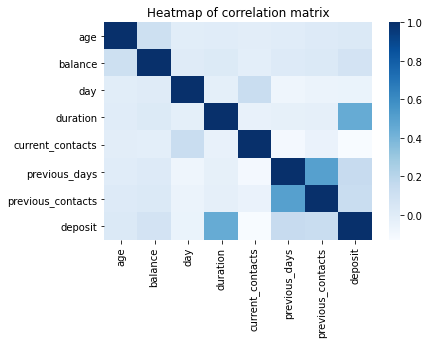

In [12]:
# correlation matrix
corr = full_dataset.corr()
sns.heatmap(corr, 
           xticklabels = corr.columns.values,
           yticklabels = corr.columns.values,
           cmap = 'Blues')

plt.title('Heatmap of correlation matrix')

corr

### Create a Test Set

In [13]:
from sklearn.model_selection import train_test_split

features = full_dataset.iloc[:,0:-1]
target = full_dataset.iloc[:,-1]

# stratified sampling based on the subscription outcome
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.20, 
                                                                            stratify = target)

In [14]:
print(features_train.shape) # 80% of original dataset
print(features_test.shape) # 20% of original dataset

(8929, 16)
(2233, 16)


In [15]:
# combine features and target for training set
train_set = pd.concat([features_train, target_train], axis = 1)

In [16]:
print(train_set.shape)
train_set.head()

(8929, 17)


,age,job,marital,education,default,balance,housing,loan,contact_mode,day,month,duration,current_contacts,previous_days,previous_contacts,previous_outcome,deposit
8478,47,admin.,single,tertiary,no,0,no,no,cellular,29,jan,137,1,-1,0,unknown,0
10641,40,management,single,secondary,no,10378,yes,no,cellular,17,nov,523,3,-1,0,unknown,0
585,35,technician,single,tertiary,no,470,yes,no,cellular,25,jul,743,13,-1,0,unknown,1
6325,78,retired,divorced,primary,no,55,no,no,telephone,5,nov,143,3,90,1,other,0
1481,46,technician,married,secondary,no,2149,yes,no,cellular,15,apr,282,2,-1,0,unknown,1


In [17]:
# subcription rate for training set
subscription_rate = train_set['deposit'].value_counts() / 8929
subscription_rate

0    0.526151
1    0.473849
Name: deposit, dtype: float64

### Exploratory Data Analysis

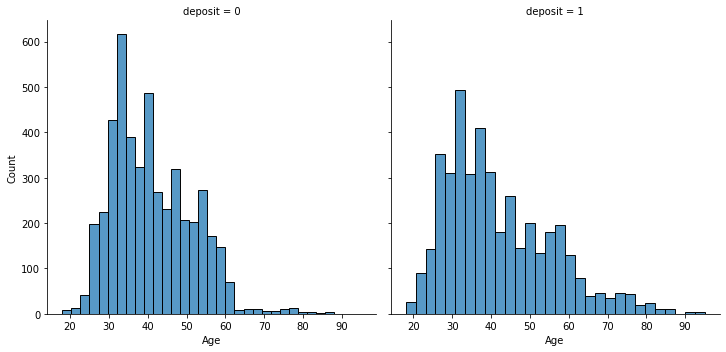

In [18]:
# visualise distribution of age

age_plot = sns.FacetGrid(train_set, col = 'deposit', height = 5)
age_plot.map(sns.histplot, 'age', bins = 30)
age_plot.set_axis_labels('Age', 'Count')

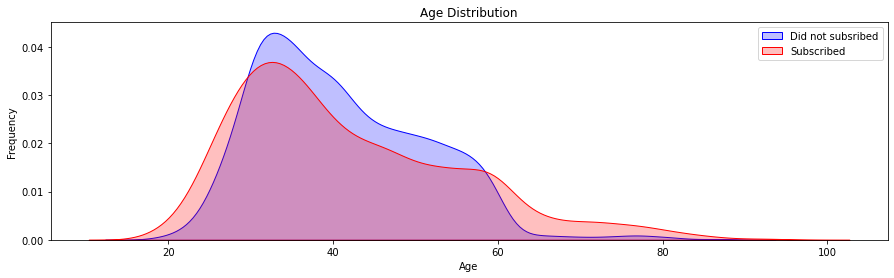

In [19]:
# Kernel Density Estimate Plot of age

fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(train_set.loc[(train_set['deposit'] == 0),'age'] , color='b',shade=True, label='Did not subsribed')
ax=sns.kdeplot(train_set.loc[(train_set['deposit'] == 1),'age'] , color='r',shade=True, label='Subscribed')
ax.set(xlabel='Age', ylabel='Frequency')
plt.title('Age Distribution')
plt.legend()

#### There is a higher proportion of clients below 30 years old and above 60 years old that subscribed for a term deposit.

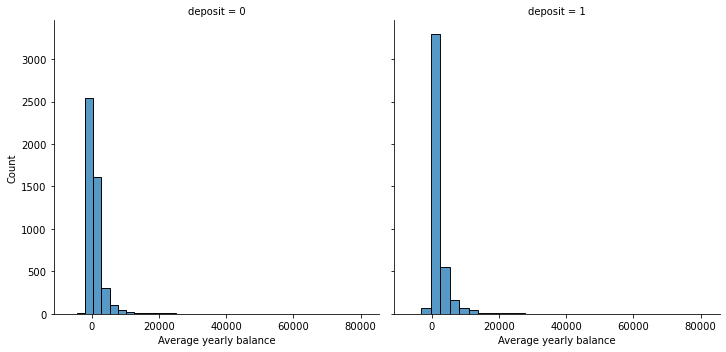

In [20]:
# visualise distribution of balance

balance_plot = sns.FacetGrid(train_set, col = 'deposit', height = 5)
balance_plot.map(sns.histplot, 'balance', bins = 30)
balance_plot.set_axis_labels('Average yearly balance', 'Count')

#### Average yearly balance did not seem to have a major impact in the term deposit subscription.

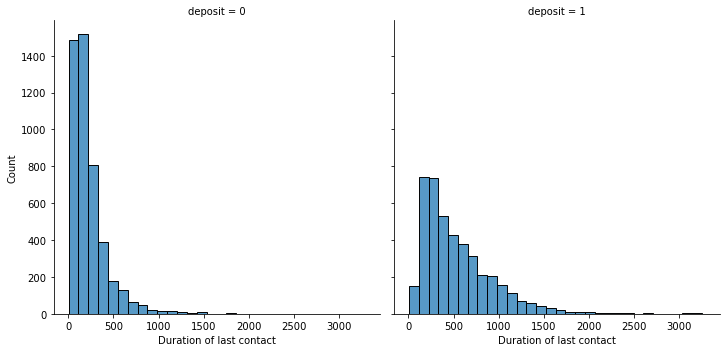

In [21]:
# visualise distribution of contact duration

duration_plot = sns.FacetGrid(train_set, col = 'deposit', height = 5)
duration_plot.map(sns.histplot, 'duration', bins = 30)
duration_plot.set_axis_labels('Duration of last contact', 'Count')

#### Clients with a longer duration of contact generally ended up subscribing for a term deposit.

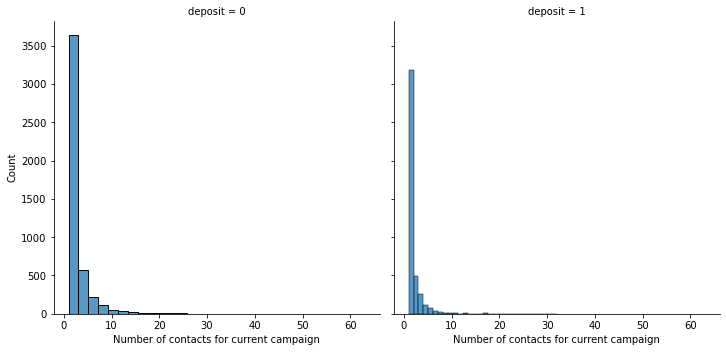

In [22]:
# visualise distribution of current contacts

contacts_plot = sns.FacetGrid(train_set, col = 'deposit', height = 5)
contacts_plot.map(sns.histplot, 'current_contacts', bins = 30)
contacts_plot.set_axis_labels('Number of contacts for current campaign', 'Count')

#### Number of contacts did not seem to have a major impact in the term deposit subscription.

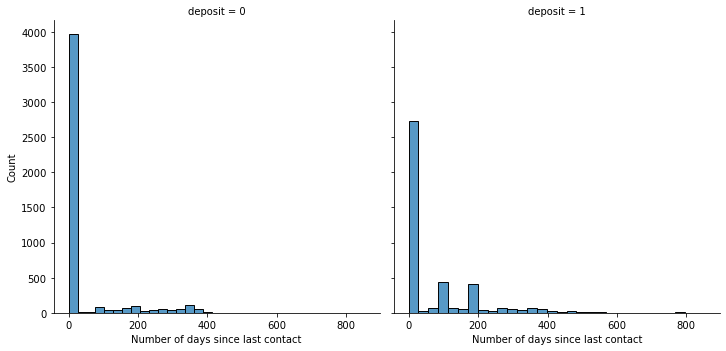

In [23]:
# visualise distribution of previous_days

prevD_plot = sns.FacetGrid(train_set, col = 'deposit', height = 5)
prevD_plot.map(sns.histplot, 'previous_days', bins = 30)
prevD_plot.set_axis_labels('Number of days since last contact', 'Count')

#### Over 2500 clients subscribed for a term deposit upon being contacted for the first time. Clients also tend to subscribe for a term deposit when being contacted after the 100-days or 200-days mark.

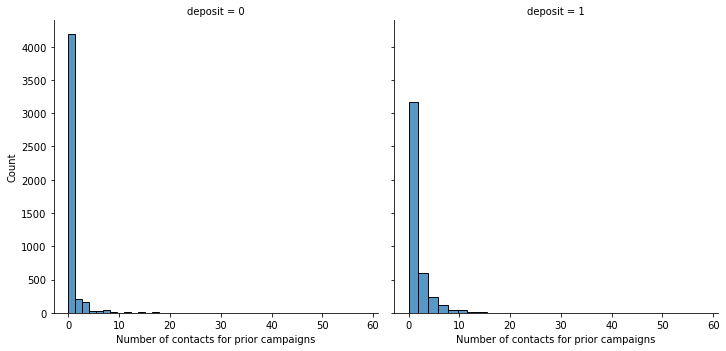

In [24]:
# visualise distribution of previous contacts

prevC_plot = sns.FacetGrid(train_set, col = 'deposit', height = 5)
prevC_plot.map(sns.histplot, 'previous_contacts', bins = 30)
prevC_plot.set_axis_labels('Number of contacts for prior campaigns', 'Count')

#### As opposed to the number fo contacts for current campaign, clients tend to subscribe for a term deposit if they wee contacted more frequently for prior campaigns.

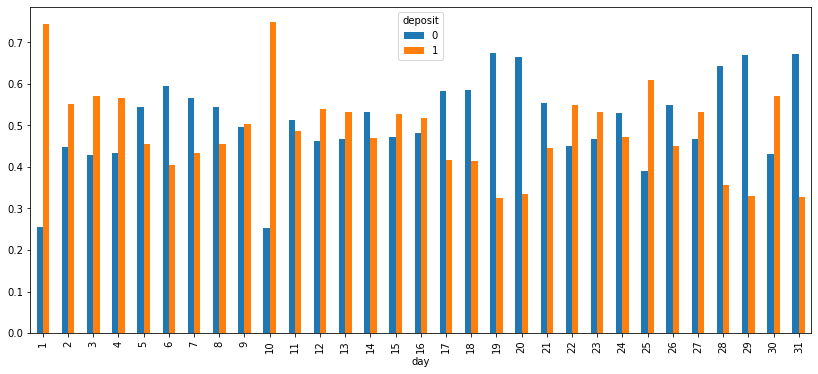

In [25]:
# which day of month resulted in more subscriptions?

day = pd.crosstab(train_set['day'], train_set['deposit']).apply(lambda r: r/r.sum(), axis=1)
day.plot(kind = 'bar', figsize = (14, 6))
plt.xticks(range(0,len(day.index)), day.index);

#### More clients subscribed for a term deposit when contacted on days 1 - 4, 10, 12 - 13, 15 - 16, 22, 25, 27 and 30.
#### When contacted on days 5 - 7, 14, 17 - 21, 26, 28 - 29 and 31, clients tend to not subscribe for a term deposit.

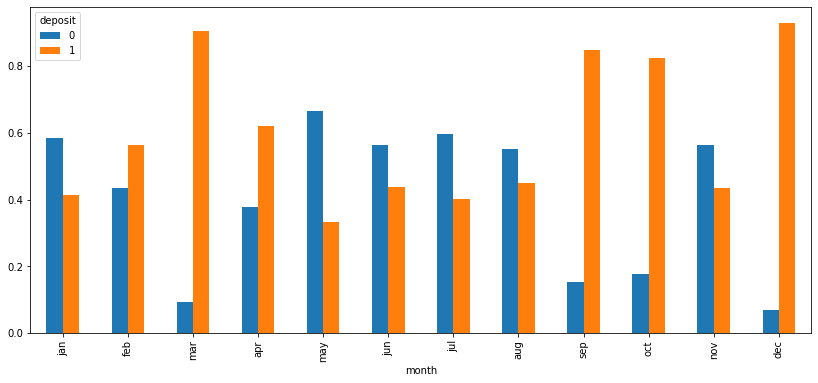

In [26]:
# which month resulted in more subscriptions?

months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

month = pd.crosstab(train_set['month'], train_set['deposit']).reindex(months).apply(lambda r: r/r.sum(), axis=1)

month.plot(kind = 'bar', figsize = (14, 6))
plt.xticks(range(0,len(month.index)), month.index);

#### More clients subscribed for a term deposit during Feb - Apr, Sep - Oct and Dec.
#### Clients tend to not subscribed during Jan, May - Aug and Nov.

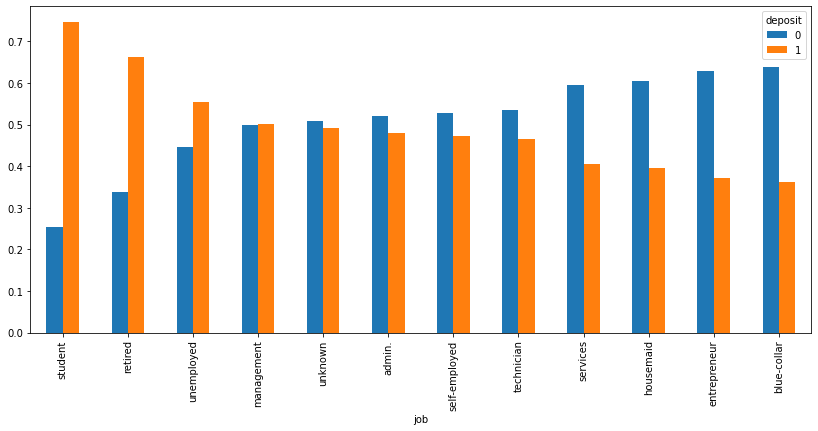

In [27]:
# which job type has a higher chance of subscription?

jobs = pd.crosstab(train_set['job'], 
                   train_set['deposit']).apply(lambda r: r/r.sum(), axis=1).sort_values(by = 1, ascending = False)

jobs.plot(kind = 'bar', figsize = (14, 6))
plt.xticks(range(0,len(jobs.index)), jobs.index);

#### Students, retirees and unemployed clients has a higher chance of subscribing for a term deposit.

<AxesSubplot:title={'center':'Has housing loan?'}, xlabel='housing'>

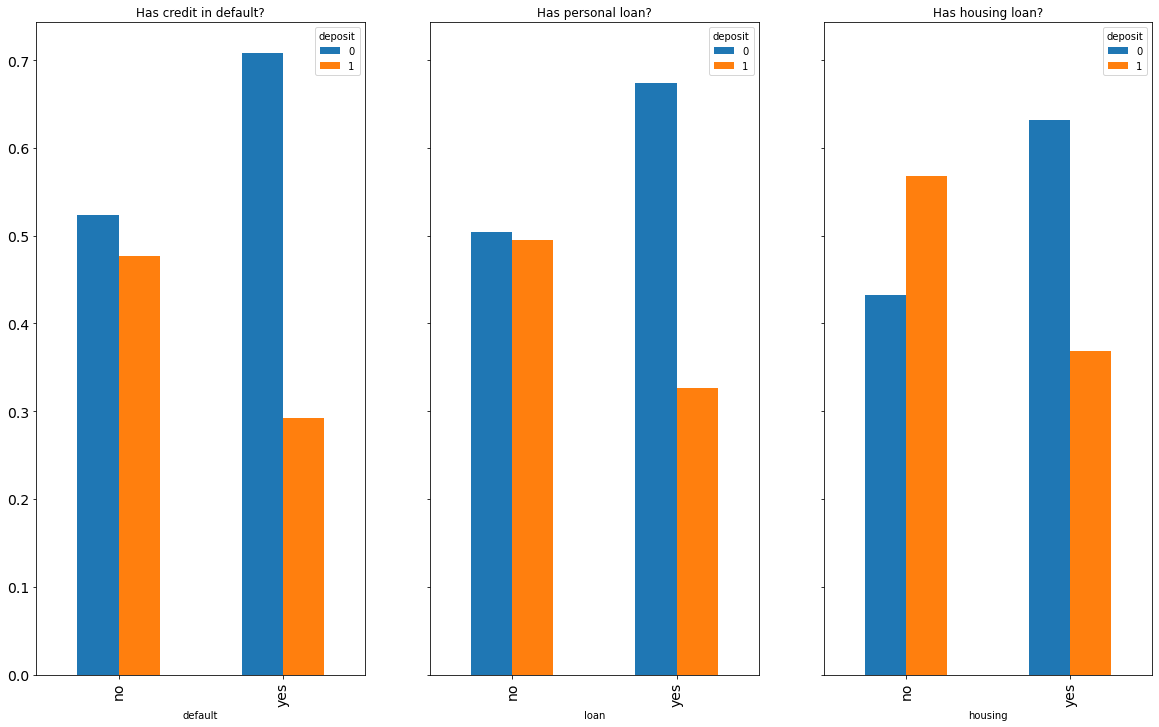

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 12), sharey = True)
fig.subplots_adjust(hspace=.3)

default = pd.crosstab(train_set['default'], train_set['deposit']).apply(lambda r: r/r.sum(), axis=1)
default.plot(kind = 'bar', ax=axes[0], fontsize = 14, title = 'Has credit in default?')

loan = pd.crosstab(train_set['loan'], train_set['deposit']).apply(lambda r: r/r.sum(), axis=1)
loan.plot(kind = 'bar', ax = axes[1], fontsize = 14, title = 'Has personal loan?')

housing = pd.crosstab(train_set['housing'], train_set['deposit']).apply(lambda r: r/r.sum(), axis=1)
housing.plot(kind = 'bar', ax = axes[2], fontsize = 14, title = 'Has housing loan?')

#### It seems like housing loan has a stronger influence on the clients' decision.

<AxesSubplot:title={'center':'Mode of contact'}, xlabel='contact_mode'>

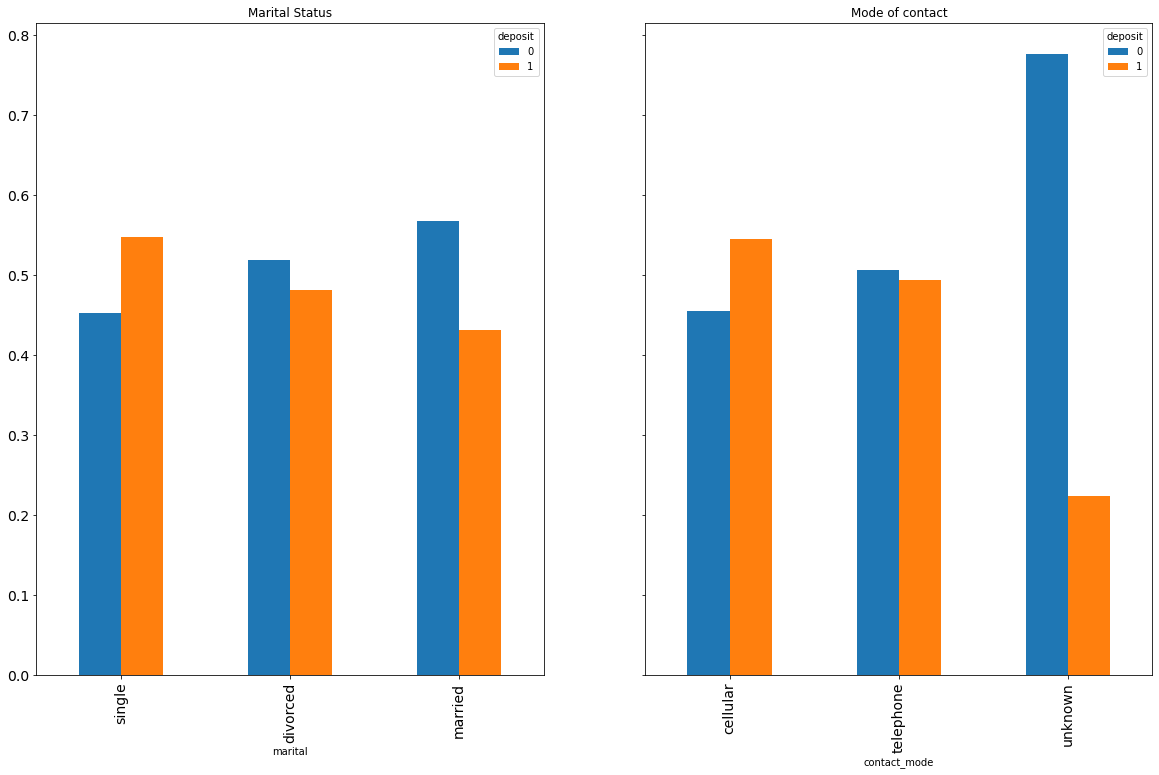

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20, 12), sharey = True)
fig.subplots_adjust(hspace=.3)

marital = pd.crosstab(train_set['marital'], 
                      train_set['deposit']).apply(lambda r: r/r.sum(), axis=1).sort_values(by = [1, 0], ascending = False)

marital.plot(kind = 'bar', ax=axes[0], fontsize = 14, title = 'Marital Status')

contact = pd.crosstab(train_set['contact_mode'], 
                      train_set['deposit']).apply(lambda r: r/r.sum(), axis=1).sort_values(by = [1, 0], ascending = False)

contact.plot(kind = 'bar', ax=axes[1], fontsize = 14, title = 'Mode of contact')

#### Single clients has a higher chance of subscribing for a term deposit as compared to divorced and married clients.
#### There is a higher chance for clients to subscribe for a term deposit if they were contacted via cellphone.

<AxesSubplot:title={'center':'Outcome of previous campaign'}, xlabel='previous_outcome'>

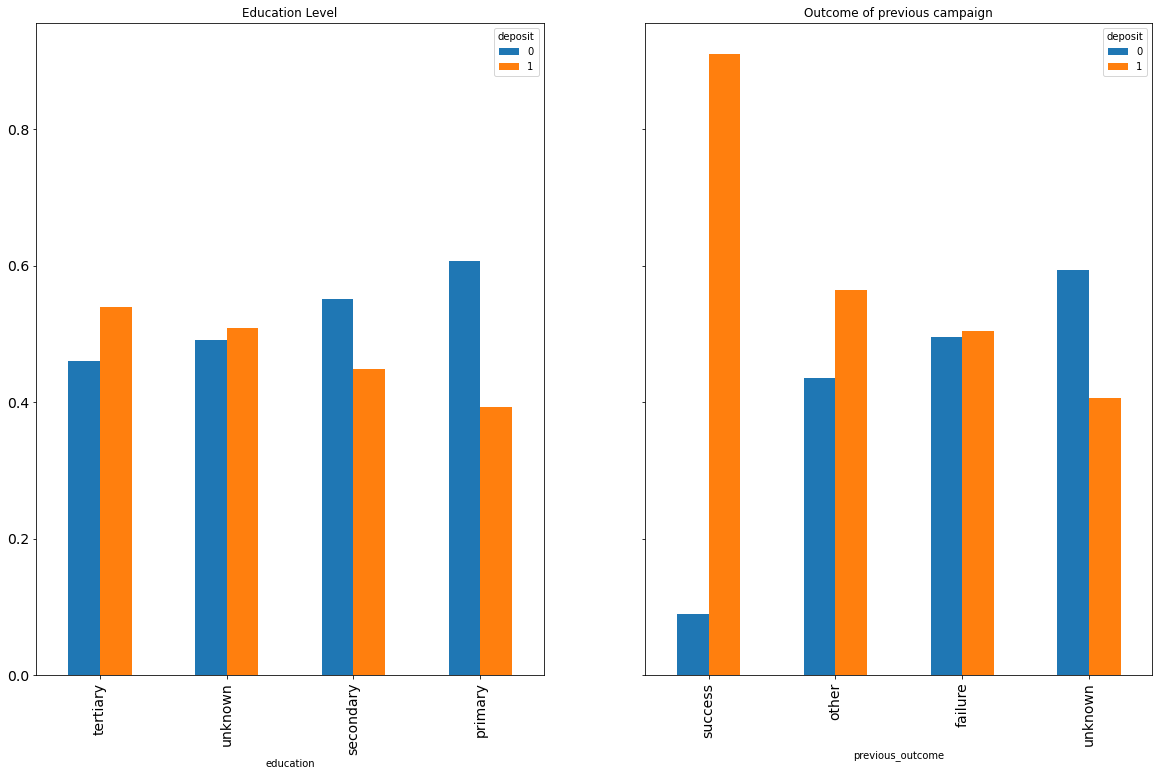

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20, 12), sharey = True)
fig.subplots_adjust(hspace=.3)

education = pd.crosstab(train_set['education'], 
                        train_set['deposit']).apply(lambda r: r/r.sum(), axis=1).sort_values(by = [1, 0], ascending = False)

education.plot(kind = 'bar', ax=axes[0], fontsize = 14, title = 'Education Level')

previous_outcome = pd.crosstab(train_set['previous_outcome'], 
                               train_set['deposit']).apply(lambda r: r/r.sum(), axis=1).sort_values(by = [1, 0], ascending = False)

previous_outcome.plot(kind = 'bar', ax=axes[1], fontsize = 14, title = 'Outcome of previous campaign')

#### Clients with a tertiary level education has a higher chance of subscribing for a term deposit.
#### Also, more than 80% of clients who had previously subscribed for a term deposit opted to subcribe for a second term.

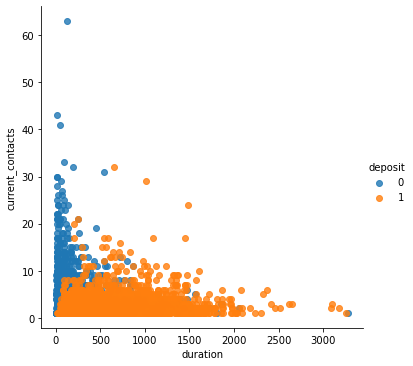

In [31]:
# scatterplot of current contacts and contact duration

sns.lmplot(x = 'duration', 
           y = 'current_contacts', 
           data = train_set,
           fit_reg = False,
           hue = 'deposit') 

#### Clents tend to subcribe for a term deposit before reaching 10 contacts with the bank.

### Data Pre-processing

We would build a transformation pipeline that can be applied to both the train and test set. <br>

This transformation pipeline will perform the following: <br>
    - encoding categorical variables with one-hot encoding
    - convert days and months (cyclical features) into a proper representation

Since, months is a year and days in a month are cyclical, doing label encoding would not be the best representation (e.g. January and December are close to each other and not far). <br>
Performing one-hot encoding would result in multiple additional features which would not be as useful for the model.

We would map each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using sin and cos trigonometric functions. For more information, click [here](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html).

In [32]:
# mapping of values for month
month_dict = {
              'jan' : 1, 'feb' : 2, 'mar' : 3,
              'apr' : 4, 'may' : 5, 'jun' : 6,
              'jul' : 7, 'aug' : 8, 'sep' : 9,
              'oct' : 10, 'nov' : 11, 'dec' : 12
             }

In [33]:
# categorical variables
cat_var = ['job', 'default', 'loan', 'housing', 'marital', 'contact_mode', 'education', 'previous_outcome']

In [34]:
def transform(df):
    """
    Prep the train and test set for machine learning.
        - encoding categorical variables with one-hot encoding
        - convert days and months (cyclical features) into a proper representaion
    
    Input: dataframe
    Output: transformed dataframe
    
    """
    df = pd.get_dummies(df, columns = cat_var)
    
    df = df.replace({'month' : month_dict})
    
    df['day_sin'] = np.sin(df.day*(2.*np.pi/24))
    df['day_cos'] = np.cos(df.day*(2.*np.pi/24))
    df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))

    df.drop(columns = ['day', 'month'], inplace = True)
    
    return df

In [35]:
train_set_prep = transform(features_train)

train_set_prep.head()

,age,balance,duration,current_contacts,previous_days,previous_contacts,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,education_tertiary,education_unknown,previous_outcome_failure,previous_outcome_other,previous_outcome_success,previous_outcome_unknown,day_sin,day_cos,month_sin,month_cos
8478,47,0,137,1,-1,0,1,0,0,0,...,1,0,0,0,0,1,0.965926,0.258819,0.000000e+00,1.000000e+00
10641,40,10378,523,3,-1,0,0,0,0,0,...,0,0,0,0,0,1,-0.965926,-0.258819,-8.660254e-01,5.000000e-01
585,35,470,743,13,-1,0,0,0,0,0,...,1,0,0,0,0,1,0.258819,0.965926,1.224647e-16,-1.000000e+00
6325,78,55,143,3,90,1,0,0,0,0,...,0,0,0,1,0,0,0.965926,0.258819,-8.660254e-01,5.000000e-01
1481,46,2149,282,2,-1,0,0,0,0,0,...,0,0,0,0,0,1,-0.707107,-0.707107,1.000000e+00,6.123234e-17


### Create Baseline Model with Logistic Regression

In [36]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

log_reg = LogisticRegression(solver = 'liblinear')

log_reg = log_reg.fit(train_set_prep, target_train)
predictions = log_reg.predict(train_set_prep)

result = f1_score(target_train, predictions)

print('F1 score for Logistic Regression Model: {}'.format(result))

F1 score for Logistic Regression Model: 0.7902676399026765


### Random Forest Classifier

In [37]:
# display scores for cross validation
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# apply 5-fold cross validation

rf = RandomForestClassifier()

rf = rf.fit(train_set_prep, target_train)

rf_result = cross_val_score(rf, train_set_prep, target_train, cv = 5, scoring = 'f1')
rf_scores = (rf_result)
display_scores(rf_scores)

Scores: [0.83542857 0.86288009 0.84610951 0.8399546  0.83475298]
Mean: 0.8438251503240475
Standard deviation: 0.010354680732244916


### Gradient Boosting Classifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

gbc = gbc.fit(train_set_prep, target_train)

gbc

GradientBoostingClassifier()

In [40]:
# apply 5-fold cross validation

gbc_result = cross_val_score(gbc, train_set_prep, target_train, cv = 5, scoring = 'f1')
gbc_scores = (gbc_result)
display_scores(gbc_scores)

Scores: [0.82318841 0.85198135 0.83826087 0.83399886 0.83429229]
Mean: 0.8363443552861703
Standard deviation: 0.009284180350868674


### Feature Importance

Text(0, 0.5, 'Feature Importance Score')

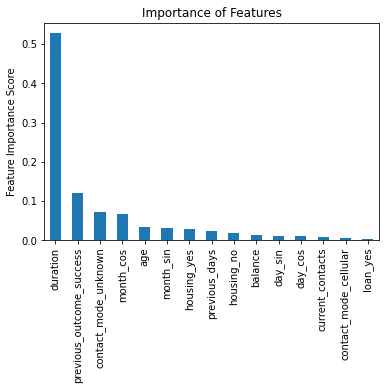

In [41]:
predictors = list(train_set_prep)

feat_imp = pd.Series(gbc.feature_importances_, predictors).sort_values(ascending = False).nlargest(15)
feat_imp.plot(kind = 'bar', title = 'Importance of Features')
plt.ylabel('Feature Importance Score')

#### Contact duration is the most important feature.

### Introduce a random noise

<AxesSubplot:xlabel='importance', ylabel='index'>

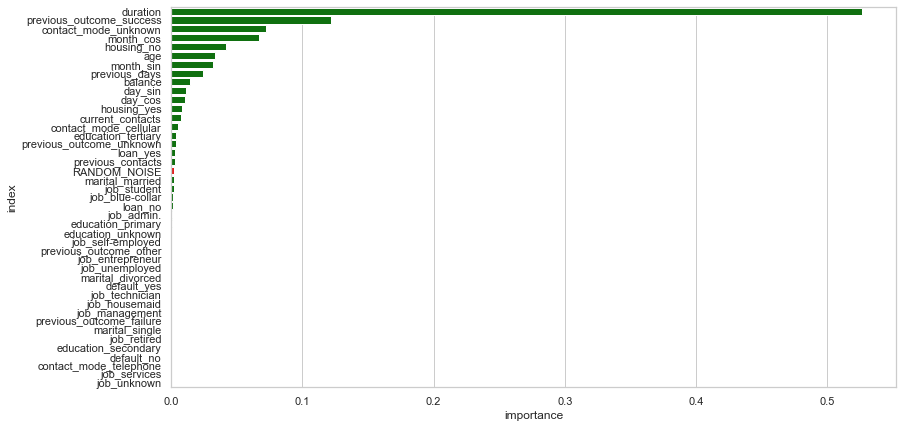

In [42]:
# Apply Random Noise to data set
train_set_prep_rnoise = train_set_prep.copy()
train_set_prep_rnoise['RANDOM_NOISE'] = np.random.normal(0, 1, train_set_prep_rnoise.shape[0])

gbc = gbc.fit(train_set_prep_rnoise, target_train)

# Get Feature Importances
feature_importances_random = pd.DataFrame(gbc.feature_importances_, 
                                          index = train_set_prep_rnoise.columns, 
                                          columns = ['importance']).sort_values('importance', ascending=False)

feature_importances_random = feature_importances_random.reset_index()

# Create Seaborn PLot
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))


clrs = ['red' if (x == 'RANDOM_NOISE' ) else 'green' for x in feature_importances_random['index']]

# Plot the Feature Importance
sns.barplot(x="importance", y='index', data=feature_importances_random,
            label="Total",  palette=clrs)

In [43]:
feature_importances_random

,index,importance
0,duration,0.526256
1,previous_outcome_success,0.121846
2,contact_mode_unknown,0.072068
3,month_cos,0.066766
4,housing_no,0.041780
5,age,0.033174
6,month_sin,0.031738
7,previous_days,0.024167
8,balance,0.014425
9,day_sin,0.011711


In [44]:
# get importance of random noise

value = float(feature_importances_random['importance'][feature_importances_random['index'] == 'RANDOM_NOISE'])

value

0.0025729861497818755

In [45]:
# get list of columns to drop if importance is below random noise

cols_to_drop = list(feature_importances_random['index'][feature_importances_random['importance'] < value])
cols_to_drop

['marital_married',
 'job_student',
 'job_blue-collar',
 'loan_no',
 'job_admin.',
 'education_primary',
 'education_unknown',
 'job_self-employed',
 'previous_outcome_other',
 'job_entrepreneur',
 'job_unemployed',
 'marital_divorced',
 'default_yes',
 'job_technician',
 'job_housemaid',
 'job_management',
 'previous_outcome_failure',
 'marital_single',
 'job_retired',
 'education_secondary',
 'default_no',
 'contact_mode_telephone',
 'job_services',
 'job_unknown']

In [46]:
train_set_prep.drop(columns = cols_to_drop, axis = 1, inplace = True)

In [47]:
train_set_prep.head()

,age,balance,duration,current_contacts,previous_days,previous_contacts,loan_yes,housing_no,housing_yes,contact_mode_cellular,contact_mode_unknown,education_tertiary,previous_outcome_success,previous_outcome_unknown,day_sin,day_cos,month_sin,month_cos
8478,47,0,137,1,-1,0,0,1,0,1,0,1,0,1,0.965926,0.258819,0.000000e+00,1.000000e+00
10641,40,10378,523,3,-1,0,0,0,1,1,0,0,0,1,-0.965926,-0.258819,-8.660254e-01,5.000000e-01
585,35,470,743,13,-1,0,0,0,1,1,0,1,0,1,0.258819,0.965926,1.224647e-16,-1.000000e+00
6325,78,55,143,3,90,1,0,1,0,0,0,0,0,0,0.965926,0.258819,-8.660254e-01,5.000000e-01
1481,46,2149,282,2,-1,0,0,0,1,1,0,0,0,1,-0.707107,-0.707107,1.000000e+00,6.123234e-17


In [48]:
# fit training set with reduced features to random forest

rf = RandomForestClassifier()

rf = rf.fit(train_set_prep, target_train)

rf_result = cross_val_score(rf, train_set_prep, target_train, cv = 5, scoring = 'f1')
rf_scores = (rf_result)
display_scores(rf_scores)

Scores: [0.83609366 0.86421174 0.85155351 0.8500283  0.85225328]
Mean: 0.8508280969630373
Standard deviation: 0.008937812919992714


#### Reducing the input features does help to increase the f1 score slightly. For our case, the mean f1 score increased by 0.3%.

### Evaluate on test set

In [49]:
# transform test set

test_set_prep = transform(features_test)
test_set_prep.drop(columns = cols_to_drop, axis = 1, inplace = True)

predictions = rf.predict(test_set_prep)
final_result = f1_score(target_test, predictions)

final_result

0.8572744014732966

#### The model is able to generalise well to new data, getting a similar score as for the training set. This is partly due to the fact that stratified sampling was done based on the target variable (subscription outcome).

### Confusion Matrix

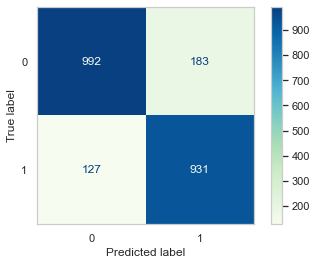

In [50]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

tn, fp, fn, tp = confusion_matrix(target_test, predictions).ravel()
plot_confusion_matrix(rf, test_set_prep, target_test, values_format = '.3g', cmap = 'GnBu')
plt.grid(False)
plt.show()

# true negative, false positive, 
# false negative, true positive

In [51]:
# get probability of target = 0 and target = 1

rf.predict_proba(test_set_prep)

array([[0.05, 0.95],
       [0.47, 0.53],
       [0.96, 0.04],
       ...,
       [1.  , 0.  ],
       [0.71, 0.29],
       [0.92, 0.08]])

#### The model performs better at predicting for clients that subscribed for a term deposit.

#### For this case, a false negative is more costly than a false positive. A false negative would mean a client is more likely to subscribe for a term deposit but no contact was made from the bank (missed out on potential revenue). A false positive would mean that the bank made contacts but the client is more likely to not subscribe for a term deposit (waste of marketing resources).

### Marketing Strategy

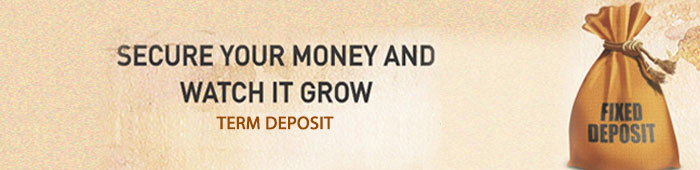

We can use the probabilities to classify the clients based on their likelihood of subscribing for a term deposit.

    - >= 0.6, clients to target
    - >= 0.4 < 0.6, to monitor and get additional data (no. of dependents, annual income, term deposit at other banks etc)
    - < 0.4, to market different services (credit card, loans etc)

For clients to target, as the contact duration is the most important feature, it is recommended to have a longer contact duration to convince the client.

It was also determined that more than 80% of clients that subscribed for a term deposit before opted to subscribe for another term. The bank could introduce some form of **loyalty marketing** (e.g. higher interest rates for second and subsequent term deposits)